Here we visualize filters and outputs using the network architecture proposed by Krizhevsky et al. for ImageNet and implemented in `caffe`.

(This page follows DeCAF visualizations originally by Yangqing Jia.)

First, import required modules, set plotting parameters, and run `./scripts/download_model_binary.py models/bvlc_reference_caffenet` to get the pretrained CaffeNet model if it hasn't already been fetched.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Make sure that caffe is on the python path:
caffe_root = '../../../'  # this file is expected to be in {caffe_root}/examples
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe
from caffe.proto import caffe_pb2
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Set Caffe to CPU mode, load the net in the test phase for inference, and configure input preprocessing.

In [4]:
caffe.set_mode_cpu()
net = caffe.Net(caffe_root + 'examples/cifar10_impact_scar/cifar10_quick.prototxt',
                caffe_root + 'examples/cifar10_impact_scar/caffemodel/normal/cifar10_impact_scar_quick_iter_10000.caffemodel',
                caffe.TEST)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
mean_blob = caffe_pb2.BlobProto()
with open( caffe_root + 'examples/cifar10_impact_scar/mean.binaryproto') as f:
        mean_blob.ParseFromString(f.read())
mean_array = np.asarray(mean_blob.data, dtype=np.float32).reshape((mean_blob.channels,mean_blob.height,mean_blob.width))
transformer.set_mean('data', mean_array) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
#transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

Classify the image by reshaping the net for the single input then doing the forward pass.

In [5]:
net.blobs['data'].reshape(1,3,32,32)
net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image(caffe_root + 'examples/cifar10_impact_scar/dataset/0/0_0001.jpg'))
out = net.forward()
print("Predicted class is #{}.".format(out['prob'].argmax()))

Predicted class is #0.


The layer features and their shapes (1 is the batch size, corresponding to the single input image in this example).

In [8]:
[(k, v.data.shape) for k, v in net.blobs.items()]

[('data', (1, 3, 32, 32)),
 ('conv1', (1, 32, 32, 32)),
 ('pool1', (1, 32, 16, 16)),
 ('conv2', (1, 32, 16, 16)),
 ('pool2', (1, 32, 8, 8)),
 ('conv3', (1, 64, 8, 8)),
 ('pool3', (1, 64, 4, 4)),
 ('ip1', (1, 64)),
 ('ip2', (1, 3)),
 ('prob', (1, 3))]

The parameters and their shapes. The parameters are `net.params['name'][0]` while biases are `net.params['name'][1]`.

In [9]:
[(k, v[0].data.shape) for k, v in net.params.items()]

[('conv1', (32, 3, 5, 5)),
 ('conv2', (32, 32, 5, 5)),
 ('conv3', (64, 32, 5, 5)),
 ('ip1', (64, 1024)),
 ('ip2', (3, 64))]

Helper functions for visualization

In [10]:
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)

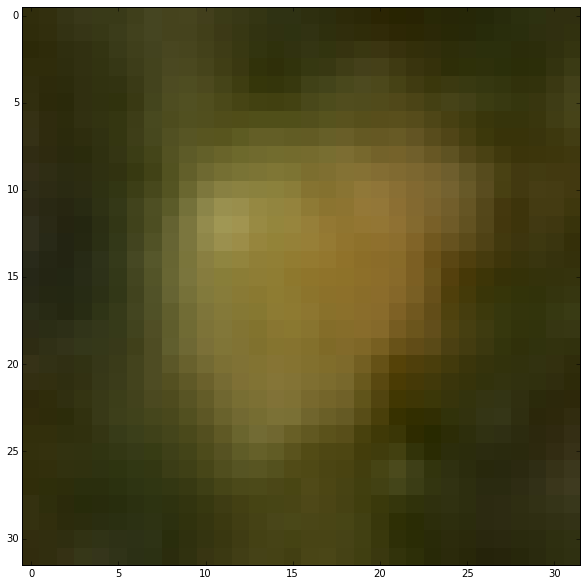

In [11]:
plt.imshow(transformer.deprocess('data', net.blobs['data'].data[0]))

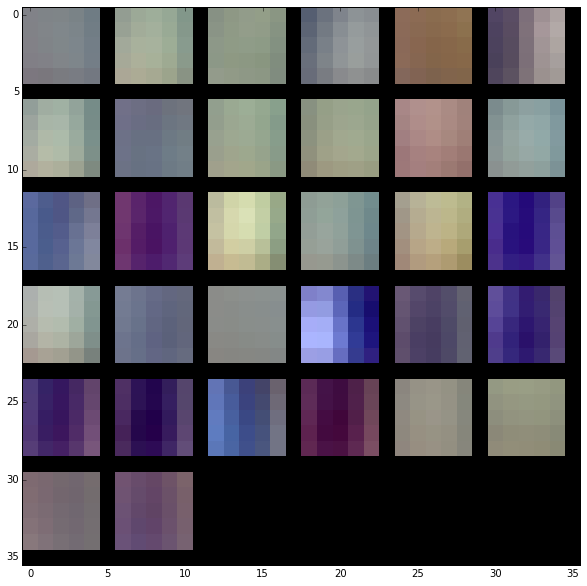

In [12]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

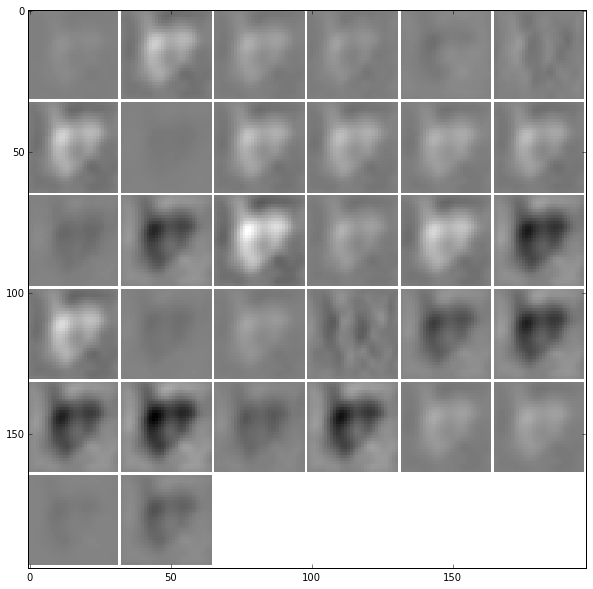

In [13]:
feat = net.blobs['conv1'].data[0, :60]
vis_square(feat, padval=1)

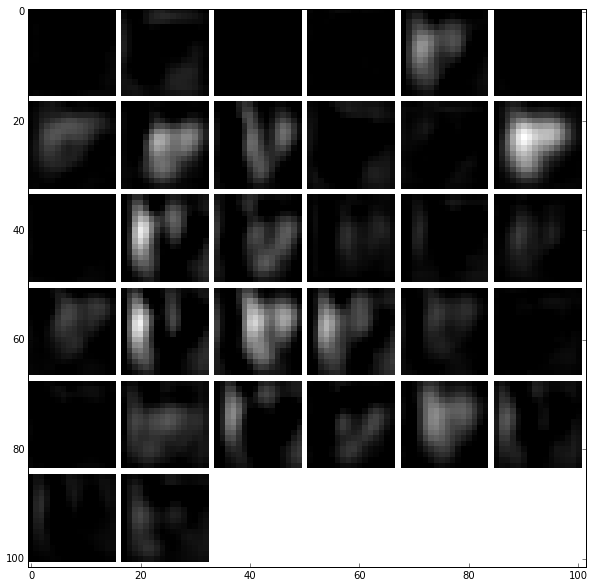

In [14]:
feat = net.blobs['conv2'].data[0, :36]
vis_square(feat, padval=1)

The third layer output, `conv3` (rectified, all 384 channels)

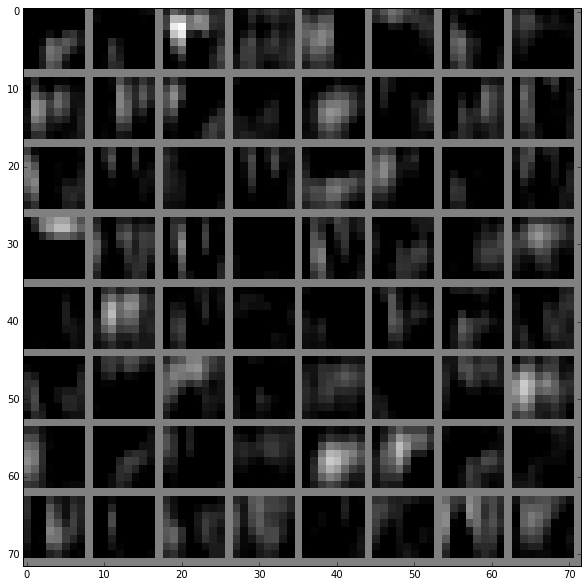

In [15]:
feat = net.blobs['conv3'].data[0]
vis_square(feat, padval=0.5)

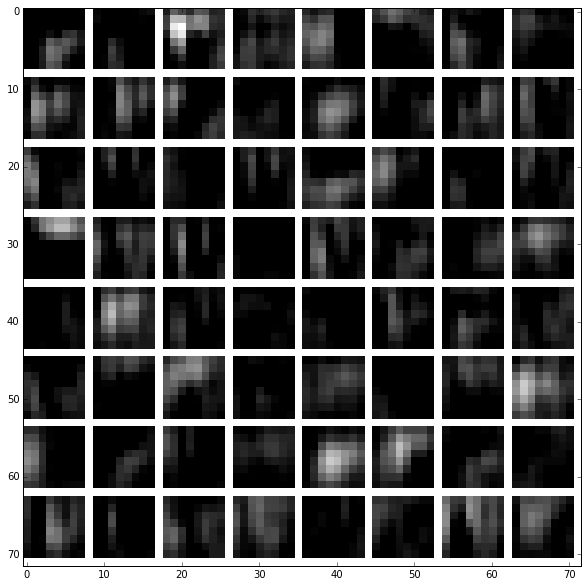

In [16]:
vis_square(feat, padval=1)

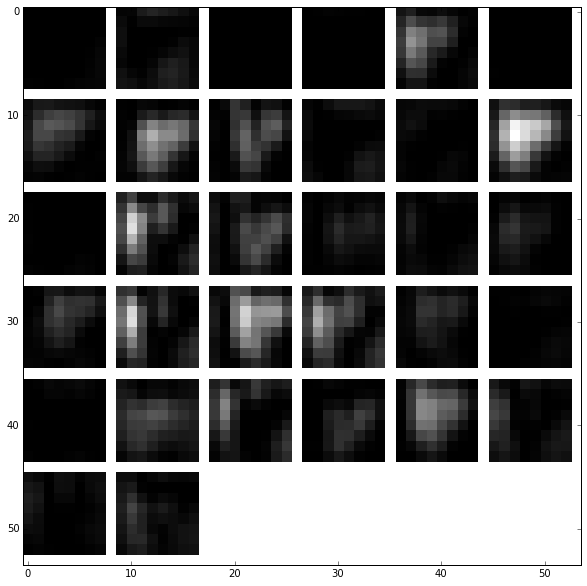

In [17]:
feat = net.blobs['pool2'].data[0]
vis_square(feat, padval=1)

(64, 4, 4)
1024


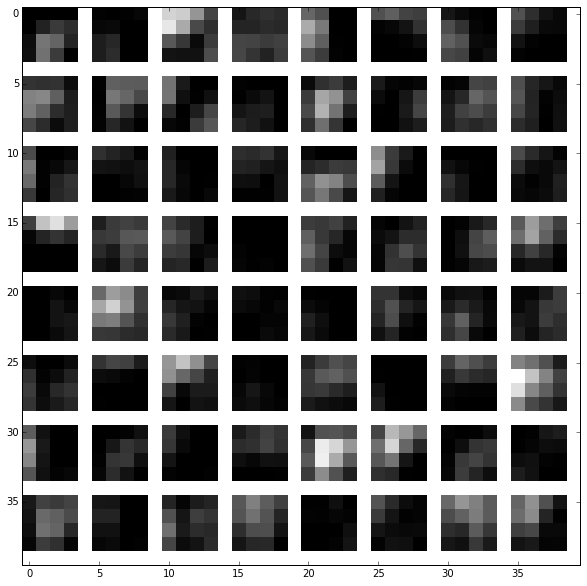

In [18]:
feat = net.blobs['pool3'].data[0]
vis_square(feat, padval=1)
print feat.shape
print feat.size

(64,)


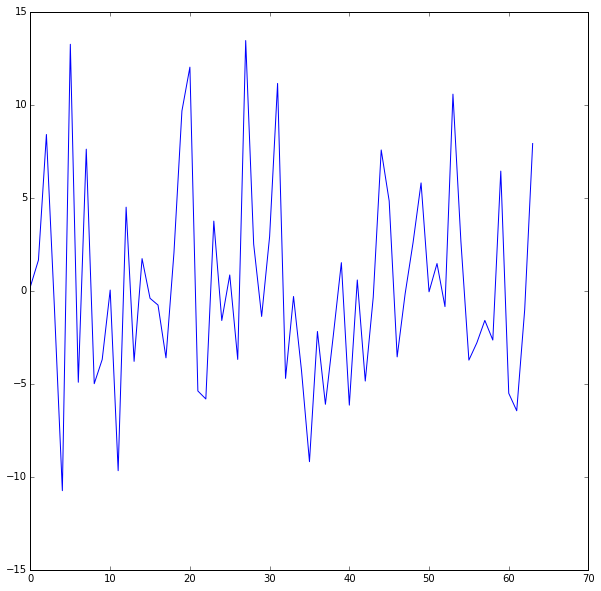

In [19]:
feat = net.blobs['ip1'].data[0]
plt.plot(feat.flat)
print feat.shape

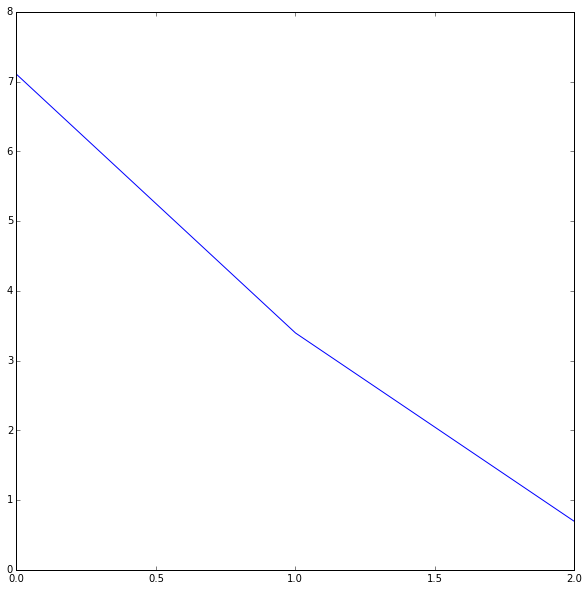

In [20]:
feat = net.blobs['ip2'].data[0]
plt.plot(feat.flat)

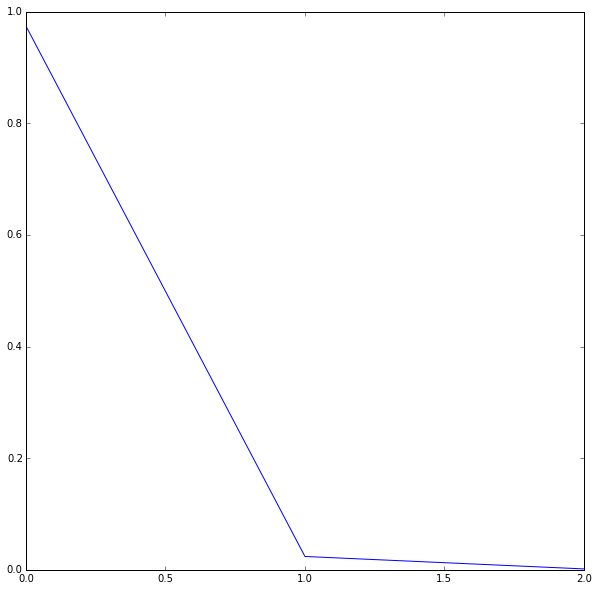

In [29]:
feat = net.blobs['prob'].data[0]
plt.plot(feat.flat)